In [1]:
import torch as np
from torchvision.utils import save_image
from torch.utils import data

from tools.celeba import CelebALoader
from dataset import Split

from models2.CSA import CSA
from tools.toml import load_option
from tools.mask import mask_iter

## 数据载入

In [2]:
header_opt = load_option('options/header.toml')
loader = CelebALoader(header_opt.data_root)
dataset = Split(loader, header_opt.fine_size)
train_data = dataset.train('bbox', pil_transform=True, alpha=0.5)
trainset = data.DataLoader(train_data,
                           batch_size=header_opt.batch_size,
                           shuffle=True)
maskset = mask_iter(header_opt.mask_root, header_opt.fine_size)
print('训练集数量：', len(trainset))
print('掩码数量：', len(maskset))

训练集数量： 162770
掩码数量： 12000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


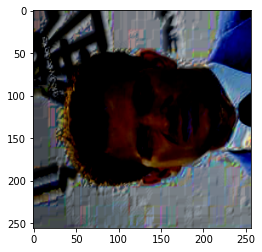

In [3]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.75)
x = train_data[14][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


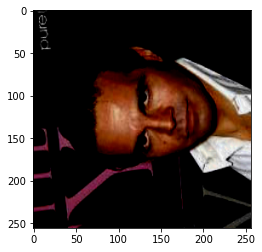

In [4]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.95)
x = train_data[7][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

## 模型载入

In [5]:
base_opt = load_option('options/base.toml')
opt = load_option('options/train.toml')
opt.update(base_opt)

model = CSA(**opt)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyReLU(negat

## 模型训练

In [6]:
import time
from random import randint


def mask_op(mask):
    mask = mask.cuda()
    mask = mask[0][0]
    mask = np.unsqueeze(mask, 0)
    mask = np.unsqueeze(mask, 1)
    mask = mask.byte()
    return mask

In [7]:
# 超参数设定
epochs = 15
display_freq = 1000
save_epoch_freq = 1

image_save_dir = model.save_dir / 'images'
load_epoch = 9
load_alpha = 0.42

In [ ]:
if not image_save_dir.exists():
    image_save_dir.mkdir(parents=True, exist_ok=True)

total_steps = 0
iter_start_time = time.time()
# 载入已经训练的模型

if load_epoch:
    model.load(f"{load_epoch}-{load_alpha}")
start_epoch = load_epoch + 1
for epoch in range(start_epoch, epochs):
    epoch_start_time = time.time()
    epoch_iter = 0
    alpha = randint(0, 100)/100 if epoch < epochs-1 else 1
    train_data = dataset.train('bbox', pil_transform=True, alpha=alpha)
    trainset = data.DataLoader(train_data,
                               batch_size=model.batch_size,
                               shuffle=True)
    for batch, mask in zip(trainset, maskset):
        image = batch[0]
        mask = mask_op(mask)
        total_steps += model.batch_size
        epoch_iter += model.batch_size
        # it not only sets the input data with mask, but also sets the latent mask.
        model.set_input(image, mask)
        model.set_gt_latent()
        model.optimize_parameters()
        if total_steps % display_freq == 0:
            real_A, real_B, fake_B = model.get_current_visuals()
            # real_A=input, real_B=ground truth fake_b=output
            pic = (np.cat([real_A, real_B, fake_B], dim=0) + 1) / 2.0
            image_name = f"epoch{epoch}-{total_steps}-{alpha}.jpg"

            save_image(pic, image_save_dir/image_name, nrow=1)
        if total_steps % 100 == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / model.batch_size
            print(
                f"Epoch/total_steps/alpha: {epoch}/{total_steps}/{alpha}", dict(errors))
    if epoch % save_epoch_freq == 0:
        print(f'保存模型 Epoch {epoch}, iters {total_steps} 在 {model.save_dir}')
        model.save(f'{epoch}-{alpha}')
    print(
        f'Epoch/Epochs {epoch}/{epochs-1} 花费时间：{time.time() - epoch_start_time}s')
    model.update_learning_rate()

Epoch/total_steps/alpha: 10/100/0.55 {'G_GAN': 5.217047214508057, 'G_L1': 4.882641315460205, 'D': 1.1768302917480469, 'F': 0.17981675267219543}
Epoch/total_steps/alpha: 10/200/0.55 {'G_GAN': 4.997414588928223, 'G_L1': 3.0683717727661133, 'D': 1.0367867946624756, 'F': 0.0899038016796112}
Epoch/total_steps/alpha: 10/300/0.55 {'G_GAN': 4.5527801513671875, 'G_L1': 6.811295986175537, 'D': 0.9918047189712524, 'F': 0.1901763528585434}
Epoch/total_steps/alpha: 10/400/0.55 {'G_GAN': 5.28938102722168, 'G_L1': 3.945913076400757, 'D': 0.9827999472618103, 'F': 0.08511260896921158}
Epoch/total_steps/alpha: 10/500/0.55 {'G_GAN': 4.956086158752441, 'G_L1': 7.877992153167725, 'D': 1.0423939228057861, 'F': 0.1337316930294037}
Epoch/total_steps/alpha: 10/600/0.55 {'G_GAN': 4.94264030456543, 'G_L1': 6.262046813964844, 'D': 0.9680197834968567, 'F': 0.043969400227069855}
Epoch/total_steps/alpha: 10/700/0.55 {'G_GAN': 4.7998433113098145, 'G_L1': 6.311676025390625, 'D': 1.0430145263671875, 'F': 0.050625503063